In [1]:
import os
import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
# Kerasの必要なコンポーネントをインポート
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from keras.optimizers import RMSprop
from keras.utils import np_utils, plot_model

# Scikit-learn(Sklearn)のインポート
#  from sklearn.datasets import fetch_openml

# データを高速かつ効率的に使えるPandasをインポート
import pandas as pd
# 数値計算を効率的に行うNumpyをインポート
import numpy as np
#グラフが簡単に描写できるMatplotlibをインポート
import matplotlib
import matplotlib.pyplot as plt

#astropy関連のインポート
from astropy.table import Table

#csv
import csv

In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [4]:
import datetime
import pydot

In [5]:
 # Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


# テスト - 一旦画像表示させてみる

In [5]:
galaxy_arr = np.load("data/npz/587727178986356823.npy")

In [19]:
# 画像
print(galaxy_arr)
print(galaxy_arr.shape)

[[1196 1188 1197 ... 1191 1191 1187]
 [1179 1185 1179 ... 1196 1189 1191]
 [1194 1189 1197 ... 1194 1199 1196]
 ...
 [1188 1189 1194 ... 1187 1202 1186]
 [1179 1189 1190 ... 1199 1195 1205]
 [1196 1196 1189 ... 1187 1189 1185]]
(60, 60)


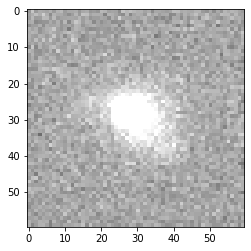

In [7]:
# 画像表示
plt.imshow(np.log10(galaxy_arr.T[::-1, ::-1]), cmap='gray', vmin=3.05, vmax=3.09)

In [17]:
#最大値参照
print(np.argmax(galaxy_arr)) #これは平坦化した際のインデックス
print(np.unravel_index(np.argmax(galaxy_arr),galaxy_arr.shape))
print(galaxy_arr[31,31])

1891
(31, 31)
1516


# テスト - Table比較

In [19]:
# ラベル
print(galaxy_arr['arr_1'])

(587727178986356823, b'00:00:00.41', b'-10:22:25.7', 59, 0.61, 0.034, 0., 0.153, 0.153, 0.051, 0.186, 0.61, 0.186, 0, 0, 1)


ここでTableと比較してみる

In [26]:
table_hontai = Table.read('GalaxyZoo1_DR_table2.fits')
table_hontai[0]

OBJID,RA,DEC,NVOTE,P_EL,P_CW,P_ACW,P_EDGE,P_DK,P_MG,P_CS,P_EL_DEBIASED,P_CS_DEBIASED,SPIRAL,ELLIPTICAL,UNCERTAIN
,hms,dms,,,,,,,,,,,,,
int64,bytes11,bytes11,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16
587727178986356823,00:00:00.41,-10:22:25.7,59,0.61,0.034,0.0,0.153,0.153,0.051,0.186,0.61,0.186,0,0,1


# データセット生成

In [67]:
# npzディレクトリのファイル名取得
#path = "data/npz"
#files = os.listdir(path)
#files_file = [f for f in files if os.path.isfile(os.path.join(path, f))]

#dataset_gal = []
#for npzname in files_file[:1]:
#    galaxy_arr = np.load('data/npz/' + npzname)
#    header = galaxy_arr['arr_1']
#    print(header)
    

(588015509806252189, b'00:00:26.31', b'+00:35:50.8', 26, 0.654, 0., 0., 0.231, 0.115, 0., 0.231, 0.394, 0.447, 0, 0, 1)


In [104]:
# まず、作成したcsvをロード
csv_obj = open('data/csv/galaxy_csv.csv')
csv_reader = csv.reader(csv_obj)
gz_table = [row for row in csv_reader]

In [105]:
# x(画像データ)のロード
x = [np.load('data/npz/' + i[0] + '.npy') for i in gz_table[:1000]]

In [106]:
print(x[0])
print(x[0].dtype)

[[1196 1188 1197 ... 1191 1191 1187]
 [1179 1185 1179 ... 1196 1189 1191]
 [1194 1189 1197 ... 1194 1199 1196]
 ...
 [1188 1189 1194 ... 1187 1202 1186]
 [1179 1189 1190 ... 1199 1195 1205]
 [1196 1196 1189 ... 1187 1189 1185]]
uint16


In [107]:
# list → nparray、およびint → float
X = np.array(x)
X = X.astype('float32')

In [108]:
print(X[0])
print(X[0].dtype)

[[1196. 1188. 1197. ... 1191. 1191. 1187.]
 [1179. 1185. 1179. ... 1196. 1189. 1191.]
 [1194. 1189. 1197. ... 1194. 1199. 1196.]
 ...
 [1188. 1189. 1194. ... 1187. 1202. 1186.]
 [1179. 1189. 1190. ... 1199. 1195. 1205.]
 [1196. 1196. 1189. ... 1187. 1189. 1185.]]
float32


In [109]:
# 正規化
for i in range(len(gz_table)):
    idx = np.unravel_index(np.argmax(X[i]), X[i].shape)
    idx_content = X[i][idx]
    X[i] = X[i]/idx_content

In [110]:
# y(正解ラベル)をロード
Y = []
for i in gz_table[:1000]:
    if i[13] == '1':
        Y.append(0)
    elif i[14] == '1':
        Y.append(1)
    elif i[15] == '1':
        Y.append(2)

In [111]:
# ワンホットエンコーディング
Y = np_utils.to_categorical(Y,3)

In [112]:
# 訓練データとテストデータを切り分ける
X_train, X_test, Y_train, Y_test = X[:800], X[800:], Y[:800], Y[800:]
Y_test_backup = Y_test

X_train = X_train.reshape(800, 60, 60, 1)
X_test  = X_test.reshape(200, 60, 60, 1)

# 両方のサイズを確認
print(len(X_train))
print(X_train[0].shape)
print(type(X_train))

800
(60, 60, 1)
<class 'numpy.ndarray'>


# モデル構築とトレーニング

In [17]:
# Parameter
batch_size = 64
epochs = 5000

# Model Construction                                                                                
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(60, 60, 1)))
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])



# Learning and Score                                                                                
history = model.fit(X_train, Y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 56, 56, 32)        832       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 52, 52, 64)        51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 128)       73856     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 128)         147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 4, 4, 128)        

Epoch 43/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8838 - accuracy: 0.5950 - val_loss: 0.9299 - val_accuracy: 0.6250
Epoch 44/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8889 - accuracy: 0.5925 - val_loss: 0.9241 - val_accuracy: 0.6250
Epoch 45/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8832 - accuracy: 0.5950 - val_loss: 0.9307 - val_accuracy: 0.6250
Epoch 46/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8936 - accuracy: 0.5938 - val_loss: 0.9235 - val_accuracy: 0.6250
Epoch 47/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8856 - accuracy: 0.5938 - val_loss: 0.9462 - val_accuracy: 0.6250
Epoch 48/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8886 - accuracy: 0.5938 - val_loss: 0.9314 - val_accuracy: 0.6250
Epoch 49/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8832 - accuracy: 0.5925 - val_loss: 0.9450 - val_ac

800/800 [==============================] - 4s 5ms/step - loss: 0.8937 - accuracy: 0.6037 - val_loss: 0.9835 - val_accuracy: 0.6200
Epoch 156/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8636 - accuracy: 0.6025 - val_loss: 1.1178 - val_accuracy: 0.6200
Epoch 157/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8656 - accuracy: 0.6037 - val_loss: 1.1204 - val_accuracy: 0.6200
Epoch 158/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8617 - accuracy: 0.6025 - val_loss: 1.0500 - val_accuracy: 0.6200
Epoch 159/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8685 - accuracy: 0.6025 - val_loss: 1.1487 - val_accuracy: 0.6200
Epoch 160/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8611 - accuracy: 0.6037 - val_loss: 1.2747 - val_accuracy: 0.6150
Epoch 161/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8694 - accuracy: 0.5938 - val_loss: 1.1066 - val_accuracy: 

800/800 [==============================] - 5s 6ms/step - loss: 0.8577 - accuracy: 0.6062 - val_loss: 1.6055 - val_accuracy: 0.6250
Epoch 268/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8618 - accuracy: 0.6075 - val_loss: 1.1209 - val_accuracy: 0.6250
Epoch 269/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8562 - accuracy: 0.6075 - val_loss: 1.1367 - val_accuracy: 0.6250
Epoch 270/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8596 - accuracy: 0.6062 - val_loss: 1.2269 - val_accuracy: 0.6250
Epoch 271/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8618 - accuracy: 0.6050 - val_loss: 1.5137 - val_accuracy: 0.6250
Epoch 272/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8700 - accuracy: 0.6087 - val_loss: 1.0510 - val_accuracy: 0.6250
Epoch 273/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8600 - accuracy: 0.6037 - val_loss: 0.9726 - val_accuracy: 

800/800 [==============================] - 4s 5ms/step - loss: 0.8512 - accuracy: 0.6087 - val_loss: 1.3592 - val_accuracy: 0.6250
Epoch 380/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8484 - accuracy: 0.6112 - val_loss: 1.3005 - val_accuracy: 0.6250
Epoch 381/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8502 - accuracy: 0.6087 - val_loss: 1.3394 - val_accuracy: 0.6250
Epoch 382/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8576 - accuracy: 0.6112 - val_loss: 1.6004 - val_accuracy: 0.6250
Epoch 383/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8568 - accuracy: 0.6100 - val_loss: 1.2650 - val_accuracy: 0.6250
Epoch 384/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8525 - accuracy: 0.6100 - val_loss: 1.2609 - val_accuracy: 0.6250
Epoch 385/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8563 - accuracy: 0.6100 - val_loss: 1.3934 - val_accuracy: 

800/800 [==============================] - 5s 6ms/step - loss: 0.8469 - accuracy: 0.6125 - val_loss: 1.5684 - val_accuracy: 0.6250
Epoch 492/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8501 - accuracy: 0.6087 - val_loss: 1.8352 - val_accuracy: 0.6250
Epoch 493/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8578 - accuracy: 0.6100 - val_loss: 1.5159 - val_accuracy: 0.6250
Epoch 494/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8533 - accuracy: 0.6100 - val_loss: 1.5801 - val_accuracy: 0.6250
Epoch 495/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8554 - accuracy: 0.6112 - val_loss: 1.0352 - val_accuracy: 0.6250
Epoch 496/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8453 - accuracy: 0.6112 - val_loss: 1.6209 - val_accuracy: 0.6200
Epoch 497/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8534 - accuracy: 0.6112 - val_loss: 1.3728 - val_accuracy: 

800/800 [==============================] - 4s 6ms/step - loss: 0.8524 - accuracy: 0.6112 - val_loss: 1.0384 - val_accuracy: 0.6250
Epoch 604/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8549 - accuracy: 0.6112 - val_loss: 1.1049 - val_accuracy: 0.6250
Epoch 605/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8551 - accuracy: 0.6087 - val_loss: 1.1178 - val_accuracy: 0.6250
Epoch 606/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8471 - accuracy: 0.6100 - val_loss: 1.2517 - val_accuracy: 0.6250
Epoch 607/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8510 - accuracy: 0.6100 - val_loss: 1.5356 - val_accuracy: 0.6250
Epoch 608/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8468 - accuracy: 0.6075 - val_loss: 1.7502 - val_accuracy: 0.6250
Epoch 609/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8495 - accuracy: 0.6112 - val_loss: 1.5516 - val_accuracy: 

800/800 [==============================] - 4s 5ms/step - loss: 0.8513 - accuracy: 0.6075 - val_loss: 2.2868 - val_accuracy: 0.6250
Epoch 716/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6112 - val_loss: 1.9642 - val_accuracy: 0.6250
Epoch 717/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8547 - accuracy: 0.6100 - val_loss: 1.4256 - val_accuracy: 0.6250
Epoch 718/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8524 - accuracy: 0.6125 - val_loss: 1.4791 - val_accuracy: 0.6250
Epoch 719/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8471 - accuracy: 0.6100 - val_loss: 1.2299 - val_accuracy: 0.6250
Epoch 720/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8514 - accuracy: 0.6100 - val_loss: 1.4040 - val_accuracy: 0.6250
Epoch 721/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8590 - accuracy: 0.6075 - val_loss: 2.2688 - val_accuracy: 

800/800 [==============================] - 4s 5ms/step - loss: 0.8555 - accuracy: 0.6087 - val_loss: 1.5625 - val_accuracy: 0.6250
Epoch 828/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8486 - accuracy: 0.6125 - val_loss: 1.9320 - val_accuracy: 0.6250
Epoch 829/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8500 - accuracy: 0.6100 - val_loss: 1.2497 - val_accuracy: 0.6250
Epoch 830/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6125 - val_loss: 2.0136 - val_accuracy: 0.6250
Epoch 831/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8432 - accuracy: 0.6112 - val_loss: 1.7732 - val_accuracy: 0.6250
Epoch 832/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8489 - accuracy: 0.6100 - val_loss: 1.8803 - val_accuracy: 0.6250
Epoch 833/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8706 - accuracy: 0.6112 - val_loss: 1.3516 - val_accuracy: 

800/800 [==============================] - 4s 5ms/step - loss: 0.8502 - accuracy: 0.6100 - val_loss: 1.2678 - val_accuracy: 0.6250
Epoch 940/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8477 - accuracy: 0.6112 - val_loss: 1.6205 - val_accuracy: 0.6250
Epoch 941/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6112 - val_loss: 1.2897 - val_accuracy: 0.6250
Epoch 942/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8728 - accuracy: 0.6075 - val_loss: 1.6458 - val_accuracy: 0.6250
Epoch 943/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8476 - accuracy: 0.6087 - val_loss: 1.9317 - val_accuracy: 0.6250
Epoch 944/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8532 - accuracy: 0.6075 - val_loss: 1.7031 - val_accuracy: 0.6250
Epoch 945/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6100 - val_loss: 1.9760 - val_accuracy: 

Epoch 1051/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8507 - accuracy: 0.6112 - val_loss: 1.8415 - val_accuracy: 0.6250
Epoch 1052/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8512 - accuracy: 0.6112 - val_loss: 1.6195 - val_accuracy: 0.6250
Epoch 1053/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8503 - accuracy: 0.6100 - val_loss: 1.2127 - val_accuracy: 0.6250
Epoch 1054/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8483 - accuracy: 0.6087 - val_loss: 1.5920 - val_accuracy: 0.6250
Epoch 1055/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8477 - accuracy: 0.6087 - val_loss: 1.4253 - val_accuracy: 0.6200
Epoch 1056/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8489 - accuracy: 0.6087 - val_loss: 1.8865 - val_accuracy: 0.6200
Epoch 1057/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8502 - accuracy: 0.6112 - val_loss: 1

Epoch 1107/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8495 - accuracy: 0.6100 - val_loss: 1.4018 - val_accuracy: 0.6250
Epoch 1108/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8464 - accuracy: 0.6100 - val_loss: 1.3702 - val_accuracy: 0.6250
Epoch 1109/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8595 - accuracy: 0.6062 - val_loss: 1.4343 - val_accuracy: 0.6250
Epoch 1110/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8483 - accuracy: 0.6112 - val_loss: 1.2037 - val_accuracy: 0.6200
Epoch 1111/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8516 - accuracy: 0.6100 - val_loss: 1.2597 - val_accuracy: 0.6250
Epoch 1112/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6112 - val_loss: 1.3667 - val_accuracy: 0.6250
Epoch 1113/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8474 - accuracy: 0.6112 - val_loss: 1

Epoch 1163/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8581 - accuracy: 0.6112 - val_loss: 1.8665 - val_accuracy: 0.6250
Epoch 1164/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8559 - accuracy: 0.6087 - val_loss: 1.5216 - val_accuracy: 0.6250
Epoch 1165/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8466 - accuracy: 0.6100 - val_loss: 1.7835 - val_accuracy: 0.6250
Epoch 1166/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8499 - accuracy: 0.6112 - val_loss: 1.1417 - val_accuracy: 0.6250
Epoch 1167/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6112 - val_loss: 1.1790 - val_accuracy: 0.6250
Epoch 1168/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8525 - accuracy: 0.6112 - val_loss: 1.5481 - val_accuracy: 0.6250
Epoch 1169/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6100 - val_loss: 1

Epoch 1219/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8495 - accuracy: 0.6125 - val_loss: 2.6041 - val_accuracy: 0.6250
Epoch 1220/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8480 - accuracy: 0.6087 - val_loss: 1.3930 - val_accuracy: 0.6200
Epoch 1221/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8486 - accuracy: 0.6112 - val_loss: 1.8968 - val_accuracy: 0.6250
Epoch 1222/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8585 - accuracy: 0.6087 - val_loss: 1.7515 - val_accuracy: 0.6250
Epoch 1223/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6100 - val_loss: 1.6752 - val_accuracy: 0.6250
Epoch 1224/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8557 - accuracy: 0.6087 - val_loss: 1.7713 - val_accuracy: 0.6250
Epoch 1225/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9179 - accuracy: 0.6087 - val_loss: 2

Epoch 1275/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8515 - accuracy: 0.6087 - val_loss: 1.2795 - val_accuracy: 0.6250
Epoch 1276/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8539 - accuracy: 0.6087 - val_loss: 1.5275 - val_accuracy: 0.6250
Epoch 1277/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8454 - accuracy: 0.6100 - val_loss: 1.4200 - val_accuracy: 0.6250
Epoch 1278/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8505 - accuracy: 0.6087 - val_loss: 1.1342 - val_accuracy: 0.6250
Epoch 1279/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6125 - val_loss: 1.3288 - val_accuracy: 0.6250
Epoch 1280/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8528 - accuracy: 0.6112 - val_loss: 1.6258 - val_accuracy: 0.6250
Epoch 1281/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8460 - accuracy: 0.6137 - val_loss: 1

Epoch 1331/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8520 - accuracy: 0.6075 - val_loss: 1.5535 - val_accuracy: 0.6250
Epoch 1332/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8466 - accuracy: 0.6087 - val_loss: 1.3824 - val_accuracy: 0.6250
Epoch 1333/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8540 - accuracy: 0.6100 - val_loss: 1.3796 - val_accuracy: 0.6250
Epoch 1334/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8450 - accuracy: 0.6100 - val_loss: 1.2270 - val_accuracy: 0.6250
Epoch 1335/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8482 - accuracy: 0.6100 - val_loss: 1.5183 - val_accuracy: 0.6250
Epoch 1336/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8478 - accuracy: 0.6112 - val_loss: 1.7815 - val_accuracy: 0.6250
Epoch 1337/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8493 - accuracy: 0.6125 - val_loss: 1

Epoch 1387/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6112 - val_loss: 1.5287 - val_accuracy: 0.6250
Epoch 1388/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8501 - accuracy: 0.6125 - val_loss: 1.3382 - val_accuracy: 0.6250
Epoch 1389/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8440 - accuracy: 0.6112 - val_loss: 2.2070 - val_accuracy: 0.6250
Epoch 1390/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8540 - accuracy: 0.6075 - val_loss: 1.9695 - val_accuracy: 0.6250
Epoch 1391/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8558 - accuracy: 0.6075 - val_loss: 1.7246 - val_accuracy: 0.6250
Epoch 1392/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8554 - accuracy: 0.6087 - val_loss: 2.0969 - val_accuracy: 0.6250
Epoch 1393/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8725 - accuracy: 0.6075 - val_loss: 1

Epoch 1443/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8715 - accuracy: 0.6062 - val_loss: 2.5986 - val_accuracy: 0.6250
Epoch 1444/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8494 - accuracy: 0.6100 - val_loss: 2.1192 - val_accuracy: 0.6250
Epoch 1445/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8498 - accuracy: 0.6112 - val_loss: 2.0765 - val_accuracy: 0.6250
Epoch 1446/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6075 - val_loss: 1.6877 - val_accuracy: 0.6250
Epoch 1447/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8479 - accuracy: 0.6087 - val_loss: 2.0428 - val_accuracy: 0.6250
Epoch 1448/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8706 - accuracy: 0.6100 - val_loss: 1.1440 - val_accuracy: 0.6250
Epoch 1449/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8523 - accuracy: 0.6087 - val_loss: 1

Epoch 1499/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8701 - accuracy: 0.6112 - val_loss: 2.5225 - val_accuracy: 0.6250
Epoch 1500/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8457 - accuracy: 0.6100 - val_loss: 2.4170 - val_accuracy: 0.6250
Epoch 1501/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8561 - accuracy: 0.6087 - val_loss: 1.1308 - val_accuracy: 0.6250
Epoch 1502/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8538 - accuracy: 0.6075 - val_loss: 1.1602 - val_accuracy: 0.6250
Epoch 1503/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8506 - accuracy: 0.6100 - val_loss: 1.9674 - val_accuracy: 0.6250
Epoch 1504/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8502 - accuracy: 0.6125 - val_loss: 1.6694 - val_accuracy: 0.6250
Epoch 1505/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6075 - val_loss: 1

Epoch 1555/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8695 - accuracy: 0.6125 - val_loss: 1.4481 - val_accuracy: 0.6250
Epoch 1556/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8445 - accuracy: 0.6100 - val_loss: 1.7594 - val_accuracy: 0.6250
Epoch 1557/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8469 - accuracy: 0.6112 - val_loss: 2.0702 - val_accuracy: 0.6250
Epoch 1558/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8500 - accuracy: 0.6062 - val_loss: 1.6386 - val_accuracy: 0.6250
Epoch 1559/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8634 - accuracy: 0.6112 - val_loss: 1.6755 - val_accuracy: 0.6250
Epoch 1560/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8486 - accuracy: 0.6100 - val_loss: 1.6129 - val_accuracy: 0.6250
Epoch 1561/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8510 - accuracy: 0.6100 - val_loss: 2

Epoch 1611/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8872 - accuracy: 0.6050 - val_loss: 2.1912 - val_accuracy: 0.6250
Epoch 1612/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8493 - accuracy: 0.6087 - val_loss: 2.0421 - val_accuracy: 0.6250
Epoch 1613/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6125 - val_loss: 2.0529 - val_accuracy: 0.6250
Epoch 1614/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8456 - accuracy: 0.6112 - val_loss: 1.6709 - val_accuracy: 0.6250
Epoch 1615/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8476 - accuracy: 0.6112 - val_loss: 1.5014 - val_accuracy: 0.6250
Epoch 1616/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8805 - accuracy: 0.6087 - val_loss: 1.4755 - val_accuracy: 0.6200
Epoch 1617/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8523 - accuracy: 0.6100 - val_loss: 1

Epoch 1667/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8498 - accuracy: 0.6125 - val_loss: 1.6106 - val_accuracy: 0.6250
Epoch 1668/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8467 - accuracy: 0.6125 - val_loss: 1.6082 - val_accuracy: 0.6250
Epoch 1669/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8510 - accuracy: 0.6100 - val_loss: 1.8894 - val_accuracy: 0.6250
Epoch 1670/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8515 - accuracy: 0.6100 - val_loss: 1.5968 - val_accuracy: 0.6250
Epoch 1671/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8540 - accuracy: 0.6112 - val_loss: 1.6775 - val_accuracy: 0.6250
Epoch 1672/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8459 - accuracy: 0.6100 - val_loss: 3.2165 - val_accuracy: 0.6250
Epoch 1673/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8599 - accuracy: 0.6137 - val_loss: 2

Epoch 1723/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8486 - accuracy: 0.6112 - val_loss: 1.9784 - val_accuracy: 0.6250
Epoch 1724/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6112 - val_loss: 2.1187 - val_accuracy: 0.6250
Epoch 1725/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8469 - accuracy: 0.6075 - val_loss: 1.7982 - val_accuracy: 0.6250
Epoch 1726/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8540 - accuracy: 0.6075 - val_loss: 1.2365 - val_accuracy: 0.6250
Epoch 1727/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8528 - accuracy: 0.6100 - val_loss: 2.4187 - val_accuracy: 0.6250
Epoch 1728/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6112 - val_loss: 2.2805 - val_accuracy: 0.6250
Epoch 1729/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6100 - val_loss: 2

Epoch 1779/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8457 - accuracy: 0.6112 - val_loss: 1.9770 - val_accuracy: 0.6250
Epoch 1780/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6100 - val_loss: 1.9949 - val_accuracy: 0.6200
Epoch 1781/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6112 - val_loss: 2.1879 - val_accuracy: 0.6250
Epoch 1782/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8511 - accuracy: 0.6100 - val_loss: 1.5017 - val_accuracy: 0.6250
Epoch 1783/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8459 - accuracy: 0.6112 - val_loss: 1.3299 - val_accuracy: 0.6250
Epoch 1784/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8545 - accuracy: 0.6100 - val_loss: 1.7477 - val_accuracy: 0.6250
Epoch 1785/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8503 - accuracy: 0.6112 - val_loss: 1

Epoch 1835/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8517 - accuracy: 0.6100 - val_loss: 1.3909 - val_accuracy: 0.6250
Epoch 1836/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8537 - accuracy: 0.6100 - val_loss: 1.6632 - val_accuracy: 0.6250
Epoch 1837/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8936 - accuracy: 0.6087 - val_loss: 1.4065 - val_accuracy: 0.6250
Epoch 1838/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8466 - accuracy: 0.6112 - val_loss: 1.3883 - val_accuracy: 0.6250
Epoch 1839/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6100 - val_loss: 1.3258 - val_accuracy: 0.6250
Epoch 1840/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8452 - accuracy: 0.6100 - val_loss: 1.4089 - val_accuracy: 0.6250
Epoch 1841/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8455 - accuracy: 0.6112 - val_loss: 1

Epoch 1891/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6100 - val_loss: 2.0966 - val_accuracy: 0.6250
Epoch 1892/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6112 - val_loss: 2.1761 - val_accuracy: 0.6250
Epoch 1893/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8486 - accuracy: 0.6112 - val_loss: 2.5208 - val_accuracy: 0.6250
Epoch 1894/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8477 - accuracy: 0.6087 - val_loss: 3.1675 - val_accuracy: 0.6250
Epoch 1895/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9347 - accuracy: 0.6100 - val_loss: 2.2800 - val_accuracy: 0.6250
Epoch 1896/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8499 - accuracy: 0.6112 - val_loss: 2.4784 - val_accuracy: 0.6250
Epoch 1897/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6112 - val_loss: 2

Epoch 1947/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8480 - accuracy: 0.6087 - val_loss: 2.6347 - val_accuracy: 0.6250
Epoch 1948/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8501 - accuracy: 0.6100 - val_loss: 2.4159 - val_accuracy: 0.6250
Epoch 1949/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8439 - accuracy: 0.6112 - val_loss: 2.5521 - val_accuracy: 0.6250
Epoch 1950/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8500 - accuracy: 0.6100 - val_loss: 2.6201 - val_accuracy: 0.6250
Epoch 1951/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8445 - accuracy: 0.6100 - val_loss: 1.9630 - val_accuracy: 0.6250
Epoch 1952/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8514 - accuracy: 0.6087 - val_loss: 1.3520 - val_accuracy: 0.6250
Epoch 1953/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8510 - accuracy: 0.6112 - val_loss: 0

Epoch 2003/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8509 - accuracy: 0.6112 - val_loss: 4.0674 - val_accuracy: 0.6250
Epoch 2004/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6100 - val_loss: 2.5139 - val_accuracy: 0.6250
Epoch 2005/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6125 - val_loss: 2.4954 - val_accuracy: 0.6250
Epoch 2006/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8495 - accuracy: 0.6112 - val_loss: 2.3876 - val_accuracy: 0.6250
Epoch 2007/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8724 - accuracy: 0.6112 - val_loss: 2.6683 - val_accuracy: 0.6250
Epoch 2008/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8496 - accuracy: 0.6112 - val_loss: 2.4671 - val_accuracy: 0.6250
Epoch 2009/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8475 - accuracy: 0.6100 - val_loss: 2

Epoch 2059/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8472 - accuracy: 0.6125 - val_loss: 1.6997 - val_accuracy: 0.6250
Epoch 2060/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8471 - accuracy: 0.6125 - val_loss: 1.5425 - val_accuracy: 0.6250
Epoch 2061/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8646 - accuracy: 0.6112 - val_loss: 1.5498 - val_accuracy: 0.6250
Epoch 2062/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8462 - accuracy: 0.6112 - val_loss: 1.5834 - val_accuracy: 0.6250
Epoch 2063/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8510 - accuracy: 0.6087 - val_loss: 2.6802 - val_accuracy: 0.6250
Epoch 2064/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8624 - accuracy: 0.6100 - val_loss: 2.1194 - val_accuracy: 0.6200
Epoch 2065/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8467 - accuracy: 0.6100 - val_loss: 2

Epoch 2115/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8606 - accuracy: 0.6100 - val_loss: 3.3076 - val_accuracy: 0.6200
Epoch 2116/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8484 - accuracy: 0.6112 - val_loss: 3.6814 - val_accuracy: 0.6200
Epoch 2117/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8467 - accuracy: 0.6087 - val_loss: 2.9572 - val_accuracy: 0.6200
Epoch 2118/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8480 - accuracy: 0.6112 - val_loss: 1.7338 - val_accuracy: 0.6200
Epoch 2119/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8527 - accuracy: 0.6087 - val_loss: 2.4821 - val_accuracy: 0.6200
Epoch 2120/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8560 - accuracy: 0.6087 - val_loss: 3.3913 - val_accuracy: 0.6200
Epoch 2121/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6112 - val_loss: 3

Epoch 2171/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8496 - accuracy: 0.6087 - val_loss: 2.0566 - val_accuracy: 0.6250
Epoch 2172/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8534 - accuracy: 0.6087 - val_loss: 2.0228 - val_accuracy: 0.6200
Epoch 2173/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8463 - accuracy: 0.6137 - val_loss: 1.9669 - val_accuracy: 0.6200
Epoch 2174/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8511 - accuracy: 0.6112 - val_loss: 3.1342 - val_accuracy: 0.6200
Epoch 2175/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8462 - accuracy: 0.6112 - val_loss: 2.9731 - val_accuracy: 0.6200
Epoch 2176/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8506 - accuracy: 0.6087 - val_loss: 1.4435 - val_accuracy: 0.6200
Epoch 2177/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8496 - accuracy: 0.6125 - val_loss: 2

Epoch 2227/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8647 - accuracy: 0.6100 - val_loss: 1.9182 - val_accuracy: 0.6250
Epoch 2228/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6100 - val_loss: 1.8295 - val_accuracy: 0.6250
Epoch 2229/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8450 - accuracy: 0.6112 - val_loss: 1.6857 - val_accuracy: 0.6250
Epoch 2230/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8482 - accuracy: 0.6100 - val_loss: 2.2919 - val_accuracy: 0.6200
Epoch 2231/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8563 - accuracy: 0.6087 - val_loss: 1.4536 - val_accuracy: 0.6250
Epoch 2232/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6062 - val_loss: 1.1438 - val_accuracy: 0.6250
Epoch 2233/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8474 - accuracy: 0.6075 - val_loss: 1

Epoch 2283/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8622 - accuracy: 0.6075 - val_loss: 2.2503 - val_accuracy: 0.6250
Epoch 2284/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8478 - accuracy: 0.6125 - val_loss: 1.8996 - val_accuracy: 0.6200
Epoch 2285/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8506 - accuracy: 0.6087 - val_loss: 1.5262 - val_accuracy: 0.6200
Epoch 2286/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8465 - accuracy: 0.6100 - val_loss: 1.5559 - val_accuracy: 0.6200
Epoch 2287/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8897 - accuracy: 0.6112 - val_loss: 2.3263 - val_accuracy: 0.6200
Epoch 2288/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8477 - accuracy: 0.6112 - val_loss: 2.0074 - val_accuracy: 0.6200
Epoch 2289/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8454 - accuracy: 0.6112 - val_loss: 3

Epoch 2339/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8881 - accuracy: 0.6062 - val_loss: 1.6993 - val_accuracy: 0.6250
Epoch 2340/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8434 - accuracy: 0.6112 - val_loss: 1.6453 - val_accuracy: 0.6250
Epoch 2341/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8504 - accuracy: 0.6112 - val_loss: 1.9027 - val_accuracy: 0.6250
Epoch 2342/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6100 - val_loss: 2.8273 - val_accuracy: 0.6250
Epoch 2343/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8459 - accuracy: 0.6125 - val_loss: 3.0411 - val_accuracy: 0.6250
Epoch 2344/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8504 - accuracy: 0.6087 - val_loss: 1.3508 - val_accuracy: 0.6250
Epoch 2345/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8470 - accuracy: 0.6112 - val_loss: 2

Epoch 2395/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8495 - accuracy: 0.6100 - val_loss: 2.9099 - val_accuracy: 0.6250
Epoch 2396/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8555 - accuracy: 0.6137 - val_loss: 2.2798 - val_accuracy: 0.6250
Epoch 2397/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8528 - accuracy: 0.6100 - val_loss: 2.4251 - val_accuracy: 0.6250
Epoch 2398/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8462 - accuracy: 0.6062 - val_loss: 2.6722 - val_accuracy: 0.6250
Epoch 2399/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8448 - accuracy: 0.6112 - val_loss: 2.4472 - val_accuracy: 0.6250
Epoch 2400/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8865 - accuracy: 0.6075 - val_loss: 1.7226 - val_accuracy: 0.6250
Epoch 2401/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8474 - accuracy: 0.6087 - val_loss: 3

Epoch 2451/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6112 - val_loss: 2.8528 - val_accuracy: 0.6250
Epoch 2452/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6112 - val_loss: 2.8327 - val_accuracy: 0.6250
Epoch 2453/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8494 - accuracy: 0.6100 - val_loss: 1.9899 - val_accuracy: 0.6250
Epoch 2454/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8462 - accuracy: 0.6125 - val_loss: 1.4609 - val_accuracy: 0.6200
Epoch 2455/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8619 - accuracy: 0.6075 - val_loss: 1.8325 - val_accuracy: 0.6200
Epoch 2456/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8477 - accuracy: 0.6087 - val_loss: 1.3350 - val_accuracy: 0.6250
Epoch 2457/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8636 - accuracy: 0.6062 - val_loss: 1

Epoch 2507/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8524 - accuracy: 0.6087 - val_loss: 1.8338 - val_accuracy: 0.6250
Epoch 2508/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8543 - accuracy: 0.6087 - val_loss: 1.7278 - val_accuracy: 0.6250
Epoch 2509/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8473 - accuracy: 0.6087 - val_loss: 1.4203 - val_accuracy: 0.6250
Epoch 2510/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8477 - accuracy: 0.6075 - val_loss: 1.7871 - val_accuracy: 0.6250
Epoch 2511/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8548 - accuracy: 0.6100 - val_loss: 1.7921 - val_accuracy: 0.6250
Epoch 2512/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8483 - accuracy: 0.6100 - val_loss: 2.8256 - val_accuracy: 0.6250
Epoch 2513/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6087 - val_loss: 1

Epoch 2563/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8476 - accuracy: 0.6112 - val_loss: 2.1840 - val_accuracy: 0.6250
Epoch 2564/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8681 - accuracy: 0.6075 - val_loss: 1.1245 - val_accuracy: 0.6250
Epoch 2565/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6087 - val_loss: 1.8518 - val_accuracy: 0.6250
Epoch 2566/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8446 - accuracy: 0.6125 - val_loss: 1.8983 - val_accuracy: 0.6250
Epoch 2567/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8506 - accuracy: 0.6100 - val_loss: 1.8843 - val_accuracy: 0.6250
Epoch 2568/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8466 - accuracy: 0.6112 - val_loss: 2.0256 - val_accuracy: 0.6250
Epoch 2569/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8639 - accuracy: 0.6100 - val_loss: 0

Epoch 2619/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8465 - accuracy: 0.6087 - val_loss: 2.7698 - val_accuracy: 0.6150
Epoch 2620/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8444 - accuracy: 0.6112 - val_loss: 3.4209 - val_accuracy: 0.6150
Epoch 2621/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8539 - accuracy: 0.6087 - val_loss: 3.3393 - val_accuracy: 0.6200
Epoch 2622/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8504 - accuracy: 0.6050 - val_loss: 3.2438 - val_accuracy: 0.6200
Epoch 2623/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8681 - accuracy: 0.6100 - val_loss: 3.5231 - val_accuracy: 0.6200
Epoch 2624/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6087 - val_loss: 2.4844 - val_accuracy: 0.6200
Epoch 2625/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8587 - accuracy: 0.6087 - val_loss: 3

Epoch 2675/5000
800/800 [==============================] - 4s 5ms/step - loss: 1.1503 - accuracy: 0.6087 - val_loss: 1.4592 - val_accuracy: 0.6250
Epoch 2676/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8525 - accuracy: 0.6087 - val_loss: 2.2262 - val_accuracy: 0.6200
Epoch 2677/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8520 - accuracy: 0.6075 - val_loss: 2.6703 - val_accuracy: 0.6200
Epoch 2678/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8463 - accuracy: 0.6100 - val_loss: 2.3060 - val_accuracy: 0.6200
Epoch 2679/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8564 - accuracy: 0.6050 - val_loss: 1.8813 - val_accuracy: 0.6200
Epoch 2680/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6100 - val_loss: 2.0051 - val_accuracy: 0.6200
Epoch 2681/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8513 - accuracy: 0.6112 - val_loss: 1

Epoch 2731/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8508 - accuracy: 0.6050 - val_loss: 2.9761 - val_accuracy: 0.6200
Epoch 2732/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8474 - accuracy: 0.6087 - val_loss: 2.4079 - val_accuracy: 0.6250
Epoch 2733/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8506 - accuracy: 0.6062 - val_loss: 2.1125 - val_accuracy: 0.6250
Epoch 2734/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8652 - accuracy: 0.6112 - val_loss: 2.5399 - val_accuracy: 0.6200
Epoch 2735/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8521 - accuracy: 0.6062 - val_loss: 2.7915 - val_accuracy: 0.6200
Epoch 2736/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8466 - accuracy: 0.6100 - val_loss: 3.4344 - val_accuracy: 0.6200
Epoch 2737/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8471 - accuracy: 0.6125 - val_loss: 4

Epoch 2787/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8547 - accuracy: 0.6062 - val_loss: 4.0890 - val_accuracy: 0.6200
Epoch 2788/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9217 - accuracy: 0.6025 - val_loss: 4.3804 - val_accuracy: 0.6200
Epoch 2789/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6100 - val_loss: 3.5646 - val_accuracy: 0.6200
Epoch 2790/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8470 - accuracy: 0.6100 - val_loss: 4.2646 - val_accuracy: 0.6200
Epoch 2791/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8446 - accuracy: 0.6112 - val_loss: 3.7571 - val_accuracy: 0.6200
Epoch 2792/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8617 - accuracy: 0.6112 - val_loss: 3.5559 - val_accuracy: 0.6200
Epoch 2793/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8568 - accuracy: 0.6075 - val_loss: 2

Epoch 2843/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8560 - accuracy: 0.6050 - val_loss: 2.2156 - val_accuracy: 0.6200
Epoch 2844/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6075 - val_loss: 2.3859 - val_accuracy: 0.6200
Epoch 2845/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8681 - accuracy: 0.6050 - val_loss: 2.8154 - val_accuracy: 0.6200
Epoch 2846/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8550 - accuracy: 0.6062 - val_loss: 2.3886 - val_accuracy: 0.6250
Epoch 2847/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8502 - accuracy: 0.6100 - val_loss: 2.7760 - val_accuracy: 0.6250
Epoch 2848/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8496 - accuracy: 0.6075 - val_loss: 2.6911 - val_accuracy: 0.6250
Epoch 2849/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8503 - accuracy: 0.6050 - val_loss: 3

Epoch 2899/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8517 - accuracy: 0.6050 - val_loss: 2.9648 - val_accuracy: 0.6200
Epoch 2900/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6100 - val_loss: 2.8018 - val_accuracy: 0.6200
Epoch 2901/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8480 - accuracy: 0.6087 - val_loss: 3.4363 - val_accuracy: 0.6200
Epoch 2902/5000
800/800 [==============================] - 4s 5ms/step - loss: 1.0105 - accuracy: 0.6037 - val_loss: 3.5039 - val_accuracy: 0.6200
Epoch 2903/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8508 - accuracy: 0.6037 - val_loss: 3.3221 - val_accuracy: 0.6200
Epoch 2904/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9127 - accuracy: 0.6037 - val_loss: 1.8891 - val_accuracy: 0.6250
Epoch 2905/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8538 - accuracy: 0.6100 - val_loss: 1

Epoch 2955/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8468 - accuracy: 0.6112 - val_loss: 4.5640 - val_accuracy: 0.6200
Epoch 2956/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8465 - accuracy: 0.6100 - val_loss: 3.4292 - val_accuracy: 0.6200
Epoch 2957/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6087 - val_loss: 3.5960 - val_accuracy: 0.6150
Epoch 2958/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8663 - accuracy: 0.6062 - val_loss: 2.8438 - val_accuracy: 0.6250
Epoch 2959/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8523 - accuracy: 0.6075 - val_loss: 3.3348 - val_accuracy: 0.6200
Epoch 2960/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8549 - accuracy: 0.6100 - val_loss: 3.1251 - val_accuracy: 0.6250
Epoch 2961/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8561 - accuracy: 0.6037 - val_loss: 2

Epoch 3011/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8543 - accuracy: 0.6075 - val_loss: 2.2298 - val_accuracy: 0.6250
Epoch 3012/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8541 - accuracy: 0.6087 - val_loss: 3.3556 - val_accuracy: 0.6250
Epoch 3013/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8609 - accuracy: 0.6037 - val_loss: 2.4672 - val_accuracy: 0.6250
Epoch 3014/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8524 - accuracy: 0.6075 - val_loss: 3.8476 - val_accuracy: 0.6250
Epoch 3015/5000
800/800 [==============================] - 4s 5ms/step - loss: 1.1171 - accuracy: 0.6050 - val_loss: 3.5640 - val_accuracy: 0.6250
Epoch 3016/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8563 - accuracy: 0.6075 - val_loss: 3.0481 - val_accuracy: 0.6250
Epoch 3017/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6075 - val_loss: 2

Epoch 3067/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8512 - accuracy: 0.6075 - val_loss: 4.3917 - val_accuracy: 0.6200
Epoch 3068/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6062 - val_loss: 2.1751 - val_accuracy: 0.6100
Epoch 3069/5000
800/800 [==============================] - 4s 5ms/step - loss: 1.0964 - accuracy: 0.6087 - val_loss: 4.7197 - val_accuracy: 0.6200
Epoch 3070/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6075 - val_loss: 3.6076 - val_accuracy: 0.6200
Epoch 3071/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8446 - accuracy: 0.6075 - val_loss: 3.8248 - val_accuracy: 0.6200
Epoch 3072/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8498 - accuracy: 0.6087 - val_loss: 2.7658 - val_accuracy: 0.6200
Epoch 3073/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8509 - accuracy: 0.6075 - val_loss: 2

Epoch 3123/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8641 - accuracy: 0.6087 - val_loss: 3.7906 - val_accuracy: 0.6200
Epoch 3124/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8476 - accuracy: 0.6087 - val_loss: 5.4173 - val_accuracy: 0.6150
Epoch 3125/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8467 - accuracy: 0.6087 - val_loss: 3.9043 - val_accuracy: 0.6150
Epoch 3126/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8914 - accuracy: 0.6075 - val_loss: 2.4172 - val_accuracy: 0.6200
Epoch 3127/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8565 - accuracy: 0.6037 - val_loss: 3.1448 - val_accuracy: 0.6150
Epoch 3128/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6087 - val_loss: 3.0172 - val_accuracy: 0.6150
Epoch 3129/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8483 - accuracy: 0.6100 - val_loss: 2

Epoch 3179/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8931 - accuracy: 0.6075 - val_loss: 5.5727 - val_accuracy: 0.6200
Epoch 3180/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8728 - accuracy: 0.6100 - val_loss: 4.6143 - val_accuracy: 0.6200
Epoch 3181/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8511 - accuracy: 0.6075 - val_loss: 4.4040 - val_accuracy: 0.6150
Epoch 3182/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8548 - accuracy: 0.6050 - val_loss: 2.9354 - val_accuracy: 0.6250
Epoch 3183/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8475 - accuracy: 0.6112 - val_loss: 2.8516 - val_accuracy: 0.6250
Epoch 3184/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8491 - accuracy: 0.6100 - val_loss: 2.9541 - val_accuracy: 0.6250
Epoch 3185/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6075 - val_loss: 5

Epoch 3235/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8535 - accuracy: 0.6062 - val_loss: 3.9124 - val_accuracy: 0.6200
Epoch 3236/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8788 - accuracy: 0.6075 - val_loss: 6.3989 - val_accuracy: 0.6200
Epoch 3237/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8854 - accuracy: 0.6062 - val_loss: 6.5481 - val_accuracy: 0.6200
Epoch 3238/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8482 - accuracy: 0.6100 - val_loss: 6.8563 - val_accuracy: 0.6200
Epoch 3239/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8613 - accuracy: 0.6062 - val_loss: 3.4237 - val_accuracy: 0.6250
Epoch 3240/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8482 - accuracy: 0.6100 - val_loss: 4.2857 - val_accuracy: 0.6200
Epoch 3241/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8521 - accuracy: 0.6087 - val_loss: 3

Epoch 3291/5000
800/800 [==============================] - 4s 5ms/step - loss: 1.6993 - accuracy: 0.6062 - val_loss: 2.6551 - val_accuracy: 0.6250
Epoch 3292/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6062 - val_loss: 2.6427 - val_accuracy: 0.6250
Epoch 3293/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8445 - accuracy: 0.6100 - val_loss: 2.9224 - val_accuracy: 0.6250
Epoch 3294/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8792 - accuracy: 0.6050 - val_loss: 2.8288 - val_accuracy: 0.6250
Epoch 3295/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8626 - accuracy: 0.6087 - val_loss: 2.6320 - val_accuracy: 0.6250
Epoch 3296/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8471 - accuracy: 0.6087 - val_loss: 3.3021 - val_accuracy: 0.6250
Epoch 3297/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8451 - accuracy: 0.6150 - val_loss: 2

Epoch 3347/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8526 - accuracy: 0.6087 - val_loss: 2.7053 - val_accuracy: 0.6200
Epoch 3348/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8484 - accuracy: 0.6112 - val_loss: 2.2452 - val_accuracy: 0.6250
Epoch 3349/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8499 - accuracy: 0.6062 - val_loss: 2.7163 - val_accuracy: 0.6250
Epoch 3350/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8570 - accuracy: 0.6075 - val_loss: 2.7071 - val_accuracy: 0.6250
Epoch 3351/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6112 - val_loss: 1.9962 - val_accuracy: 0.6250
Epoch 3352/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8577 - accuracy: 0.6062 - val_loss: 3.2907 - val_accuracy: 0.6250
Epoch 3353/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8515 - accuracy: 0.6087 - val_loss: 3

Epoch 3403/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6075 - val_loss: 2.2478 - val_accuracy: 0.6250
Epoch 3404/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8501 - accuracy: 0.6075 - val_loss: 1.8007 - val_accuracy: 0.6250
Epoch 3405/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8534 - accuracy: 0.6062 - val_loss: 1.6412 - val_accuracy: 0.6250
Epoch 3406/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8514 - accuracy: 0.6100 - val_loss: 1.8440 - val_accuracy: 0.6250
Epoch 3407/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8527 - accuracy: 0.6087 - val_loss: 2.4100 - val_accuracy: 0.6250
Epoch 3408/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8507 - accuracy: 0.6062 - val_loss: 1.8712 - val_accuracy: 0.6250
Epoch 3409/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8493 - accuracy: 0.6087 - val_loss: 4

Epoch 3459/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8772 - accuracy: 0.6075 - val_loss: 1.9976 - val_accuracy: 0.6250
Epoch 3460/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8543 - accuracy: 0.6050 - val_loss: 1.7359 - val_accuracy: 0.6250
Epoch 3461/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8548 - accuracy: 0.6087 - val_loss: 1.8299 - val_accuracy: 0.6250
Epoch 3462/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8489 - accuracy: 0.6062 - val_loss: 2.8508 - val_accuracy: 0.6250
Epoch 3463/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8530 - accuracy: 0.6012 - val_loss: 2.6566 - val_accuracy: 0.6250
Epoch 3464/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8540 - accuracy: 0.6100 - val_loss: 2.3318 - val_accuracy: 0.6250
Epoch 3465/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8512 - accuracy: 0.6062 - val_loss: 2

Epoch 3515/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8549 - accuracy: 0.6075 - val_loss: 4.7773 - val_accuracy: 0.6200
Epoch 3516/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8579 - accuracy: 0.6075 - val_loss: 4.2134 - val_accuracy: 0.6200
Epoch 3517/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8459 - accuracy: 0.6100 - val_loss: 4.2876 - val_accuracy: 0.6200
Epoch 3518/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8466 - accuracy: 0.6050 - val_loss: 4.3915 - val_accuracy: 0.6200
Epoch 3519/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8484 - accuracy: 0.6075 - val_loss: 4.5282 - val_accuracy: 0.6200
Epoch 3520/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8506 - accuracy: 0.6100 - val_loss: 4.0896 - val_accuracy: 0.6200
Epoch 3521/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8583 - accuracy: 0.6075 - val_loss: 2

Epoch 3571/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8654 - accuracy: 0.6112 - val_loss: 2.6965 - val_accuracy: 0.6200
Epoch 3572/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8474 - accuracy: 0.6075 - val_loss: 2.9247 - val_accuracy: 0.6200
Epoch 3573/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8545 - accuracy: 0.6100 - val_loss: 2.7788 - val_accuracy: 0.6200
Epoch 3574/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8517 - accuracy: 0.6087 - val_loss: 3.6134 - val_accuracy: 0.6200
Epoch 3575/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8530 - accuracy: 0.6100 - val_loss: 2.8546 - val_accuracy: 0.6200
Epoch 3576/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8440 - accuracy: 0.6137 - val_loss: 2.9194 - val_accuracy: 0.6200
Epoch 3577/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8484 - accuracy: 0.6112 - val_loss: 3

Epoch 3627/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9804 - accuracy: 0.6062 - val_loss: 5.4982 - val_accuracy: 0.6200
Epoch 3628/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8678 - accuracy: 0.6125 - val_loss: 4.8015 - val_accuracy: 0.6200
Epoch 3629/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8504 - accuracy: 0.6050 - val_loss: 4.8731 - val_accuracy: 0.6200
Epoch 3630/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8478 - accuracy: 0.6087 - val_loss: 5.2527 - val_accuracy: 0.6200
Epoch 3631/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8567 - accuracy: 0.6050 - val_loss: 4.8561 - val_accuracy: 0.6200
Epoch 3632/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8522 - accuracy: 0.6125 - val_loss: 2.7494 - val_accuracy: 0.6200
Epoch 3633/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8551 - accuracy: 0.6075 - val_loss: 4

Epoch 3683/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8503 - accuracy: 0.6100 - val_loss: 1.5143 - val_accuracy: 0.6250
Epoch 3684/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8518 - accuracy: 0.6062 - val_loss: 2.8273 - val_accuracy: 0.6250
Epoch 3685/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8626 - accuracy: 0.6087 - val_loss: 0.9095 - val_accuracy: 0.6250
Epoch 3686/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8741 - accuracy: 0.6062 - val_loss: 1.7359 - val_accuracy: 0.6250
Epoch 3687/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9335 - accuracy: 0.6087 - val_loss: 2.1972 - val_accuracy: 0.6250
Epoch 3688/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8518 - accuracy: 0.6112 - val_loss: 4.2118 - val_accuracy: 0.6250
Epoch 3689/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8498 - accuracy: 0.6087 - val_loss: 4

Epoch 3739/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8640 - accuracy: 0.6137 - val_loss: 2.8072 - val_accuracy: 0.6200
Epoch 3740/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8573 - accuracy: 0.6050 - val_loss: 3.1606 - val_accuracy: 0.6250
Epoch 3741/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8462 - accuracy: 0.6112 - val_loss: 2.8126 - val_accuracy: 0.6250
Epoch 3742/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8743 - accuracy: 0.6150 - val_loss: 2.4795 - val_accuracy: 0.6150
Epoch 3743/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9027 - accuracy: 0.6087 - val_loss: 4.7524 - val_accuracy: 0.6200
Epoch 3744/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8515 - accuracy: 0.6137 - val_loss: 4.1740 - val_accuracy: 0.6200
Epoch 3745/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8509 - accuracy: 0.6087 - val_loss: 3

Epoch 3795/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8444 - accuracy: 0.6137 - val_loss: 5.2300 - val_accuracy: 0.6050
Epoch 3796/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8514 - accuracy: 0.6050 - val_loss: 4.7873 - val_accuracy: 0.6150
Epoch 3797/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8524 - accuracy: 0.6062 - val_loss: 4.4144 - val_accuracy: 0.6200
Epoch 3798/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9001 - accuracy: 0.6100 - val_loss: 5.7036 - val_accuracy: 0.6200
Epoch 3799/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8447 - accuracy: 0.6112 - val_loss: 4.6407 - val_accuracy: 0.6150
Epoch 3800/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8507 - accuracy: 0.6087 - val_loss: 5.7391 - val_accuracy: 0.6200
Epoch 3801/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6075 - val_loss: 3

Epoch 3851/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8465 - accuracy: 0.6112 - val_loss: 3.0059 - val_accuracy: 0.6200
Epoch 3852/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8513 - accuracy: 0.6075 - val_loss: 3.2111 - val_accuracy: 0.6200
Epoch 3853/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6087 - val_loss: 1.0875 - val_accuracy: 0.6250
Epoch 3854/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8571 - accuracy: 0.6075 - val_loss: 2.5237 - val_accuracy: 0.6200
Epoch 3855/5000
800/800 [==============================] - 4s 5ms/step - loss: 2.0366 - accuracy: 0.6037 - val_loss: 2.0705 - val_accuracy: 0.6200
Epoch 3856/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8625 - accuracy: 0.6062 - val_loss: 2.0013 - val_accuracy: 0.6200
Epoch 3857/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8542 - accuracy: 0.6087 - val_loss: 2

Epoch 3907/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9169 - accuracy: 0.6087 - val_loss: 1.7147 - val_accuracy: 0.6250
Epoch 3908/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8531 - accuracy: 0.6087 - val_loss: 2.9459 - val_accuracy: 0.6250
Epoch 3909/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8460 - accuracy: 0.6087 - val_loss: 1.9406 - val_accuracy: 0.6200
Epoch 3910/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8516 - accuracy: 0.6087 - val_loss: 1.7473 - val_accuracy: 0.6200
Epoch 3911/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8486 - accuracy: 0.6087 - val_loss: 2.7052 - val_accuracy: 0.6200
Epoch 3912/5000
800/800 [==============================] - 4s 6ms/step - loss: 0.8471 - accuracy: 0.6112 - val_loss: 2.1519 - val_accuracy: 0.6200
Epoch 3913/5000
800/800 [==============================] - 5s 6ms/step - loss: 0.8510 - accuracy: 0.6100 - val_loss: 4

Epoch 3963/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8441 - accuracy: 0.6112 - val_loss: 2.5372 - val_accuracy: 0.6250
Epoch 3964/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8446 - accuracy: 0.6125 - val_loss: 2.1612 - val_accuracy: 0.6200
Epoch 3965/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8505 - accuracy: 0.6087 - val_loss: 2.6653 - val_accuracy: 0.6250
Epoch 3966/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8718 - accuracy: 0.6087 - val_loss: 1.2004 - val_accuracy: 0.6250
Epoch 3967/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8683 - accuracy: 0.6037 - val_loss: 3.9998 - val_accuracy: 0.6250
Epoch 3968/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8867 - accuracy: 0.6025 - val_loss: 1.3787 - val_accuracy: 0.6250
Epoch 3969/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8607 - accuracy: 0.6075 - val_loss: 1

Epoch 4019/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8551 - accuracy: 0.6025 - val_loss: 3.3529 - val_accuracy: 0.6250
Epoch 4020/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9935 - accuracy: 0.6112 - val_loss: 2.2034 - val_accuracy: 0.6250
Epoch 4021/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8455 - accuracy: 0.6112 - val_loss: 2.9057 - val_accuracy: 0.6250
Epoch 4022/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6112 - val_loss: 1.5572 - val_accuracy: 0.6250
Epoch 4023/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8436 - accuracy: 0.6112 - val_loss: 1.7060 - val_accuracy: 0.6250
Epoch 4024/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6112 - val_loss: 2.2554 - val_accuracy: 0.6250
Epoch 4025/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8463 - accuracy: 0.6087 - val_loss: 1

Epoch 4075/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8476 - accuracy: 0.6100 - val_loss: 3.0927 - val_accuracy: 0.6250
Epoch 4076/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8440 - accuracy: 0.6112 - val_loss: 2.5753 - val_accuracy: 0.6250
Epoch 4077/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8661 - accuracy: 0.6087 - val_loss: 2.9821 - val_accuracy: 0.6250
Epoch 4078/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8537 - accuracy: 0.6112 - val_loss: 2.4045 - val_accuracy: 0.6250
Epoch 4079/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8499 - accuracy: 0.6100 - val_loss: 2.8476 - val_accuracy: 0.6250
Epoch 4080/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8494 - accuracy: 0.6100 - val_loss: 3.6276 - val_accuracy: 0.6250
Epoch 4081/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8446 - accuracy: 0.6112 - val_loss: 2

Epoch 4131/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8530 - accuracy: 0.6112 - val_loss: 2.0523 - val_accuracy: 0.6250
Epoch 4132/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8505 - accuracy: 0.6100 - val_loss: 2.0664 - val_accuracy: 0.6250
Epoch 4133/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8480 - accuracy: 0.6100 - val_loss: 1.3681 - val_accuracy: 0.6250
Epoch 4134/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8537 - accuracy: 0.6075 - val_loss: 3.7474 - val_accuracy: 0.6200
Epoch 4135/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8448 - accuracy: 0.6125 - val_loss: 3.8622 - val_accuracy: 0.6200
Epoch 4136/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8451 - accuracy: 0.6125 - val_loss: 3.9147 - val_accuracy: 0.6200
Epoch 4137/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8537 - accuracy: 0.6112 - val_loss: 4

Epoch 4187/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6100 - val_loss: 4.7203 - val_accuracy: 0.6250
Epoch 4188/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8802 - accuracy: 0.6062 - val_loss: 1.2762 - val_accuracy: 0.6200
Epoch 4189/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8934 - accuracy: 0.6087 - val_loss: 1.4193 - val_accuracy: 0.6200
Epoch 4190/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8475 - accuracy: 0.6100 - val_loss: 1.7306 - val_accuracy: 0.6200
Epoch 4191/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8507 - accuracy: 0.6100 - val_loss: 2.0113 - val_accuracy: 0.6200
Epoch 4192/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8461 - accuracy: 0.6100 - val_loss: 2.1113 - val_accuracy: 0.6200
Epoch 4193/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8459 - accuracy: 0.6100 - val_loss: 2

Epoch 4243/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8511 - accuracy: 0.6075 - val_loss: 3.0634 - val_accuracy: 0.6250
Epoch 4244/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6100 - val_loss: 2.8388 - val_accuracy: 0.6250
Epoch 4245/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8467 - accuracy: 0.6125 - val_loss: 1.8376 - val_accuracy: 0.6250
Epoch 4246/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6100 - val_loss: 2.8386 - val_accuracy: 0.6200
Epoch 4247/5000
800/800 [==============================] - 4s 5ms/step - loss: 1.0459 - accuracy: 0.6037 - val_loss: 1.6882 - val_accuracy: 0.6250
Epoch 4248/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8586 - accuracy: 0.6087 - val_loss: 1.8414 - val_accuracy: 0.6250
Epoch 4249/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8576 - accuracy: 0.6062 - val_loss: 1

Epoch 4299/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8531 - accuracy: 0.6100 - val_loss: 6.5494 - val_accuracy: 0.6250
Epoch 4300/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6100 - val_loss: 5.3265 - val_accuracy: 0.6250
Epoch 4301/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8526 - accuracy: 0.6087 - val_loss: 4.1290 - val_accuracy: 0.6250
Epoch 4302/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9821 - accuracy: 0.6037 - val_loss: 5.8778 - val_accuracy: 0.6250
Epoch 4303/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8577 - accuracy: 0.6075 - val_loss: 4.6985 - val_accuracy: 0.6250
Epoch 4304/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8480 - accuracy: 0.6087 - val_loss: 4.9287 - val_accuracy: 0.6250
Epoch 4305/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8471 - accuracy: 0.6100 - val_loss: 4

Epoch 4355/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8541 - accuracy: 0.6100 - val_loss: 4.6124 - val_accuracy: 0.6200
Epoch 4356/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8911 - accuracy: 0.6112 - val_loss: 6.1277 - val_accuracy: 0.6250
Epoch 4357/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8545 - accuracy: 0.6112 - val_loss: 4.8198 - val_accuracy: 0.6250
Epoch 4358/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6087 - val_loss: 3.9569 - val_accuracy: 0.6250
Epoch 4359/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8513 - accuracy: 0.6075 - val_loss: 3.6368 - val_accuracy: 0.6200
Epoch 4360/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8612 - accuracy: 0.6087 - val_loss: 3.8383 - val_accuracy: 0.6250
Epoch 4361/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8704 - accuracy: 0.6075 - val_loss: 4

Epoch 4411/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8494 - accuracy: 0.6100 - val_loss: 6.5472 - val_accuracy: 0.6250
Epoch 4412/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8530 - accuracy: 0.6087 - val_loss: 4.5764 - val_accuracy: 0.6250
Epoch 4413/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6125 - val_loss: 3.4347 - val_accuracy: 0.6250
Epoch 4414/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8540 - accuracy: 0.6050 - val_loss: 3.1872 - val_accuracy: 0.6250
Epoch 4415/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8488 - accuracy: 0.6112 - val_loss: 3.1800 - val_accuracy: 0.6250
Epoch 4416/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9050 - accuracy: 0.6125 - val_loss: 5.2625 - val_accuracy: 0.6200
Epoch 4417/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8490 - accuracy: 0.6100 - val_loss: 3

Epoch 4467/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8454 - accuracy: 0.6100 - val_loss: 4.2217 - val_accuracy: 0.6250
Epoch 4468/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8472 - accuracy: 0.6112 - val_loss: 5.3020 - val_accuracy: 0.6250
Epoch 4469/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8554 - accuracy: 0.6075 - val_loss: 3.2114 - val_accuracy: 0.6250
Epoch 4470/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8507 - accuracy: 0.6112 - val_loss: 4.7467 - val_accuracy: 0.6250
Epoch 4471/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8485 - accuracy: 0.6075 - val_loss: 5.6541 - val_accuracy: 0.6250
Epoch 4472/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8630 - accuracy: 0.6100 - val_loss: 3.6453 - val_accuracy: 0.6250
Epoch 4473/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8445 - accuracy: 0.6100 - val_loss: 5

Epoch 4523/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8546 - accuracy: 0.6075 - val_loss: 6.7592 - val_accuracy: 0.6200
Epoch 4524/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8512 - accuracy: 0.6100 - val_loss: 6.8926 - val_accuracy: 0.6250
Epoch 4525/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8538 - accuracy: 0.6112 - val_loss: 4.2839 - val_accuracy: 0.6250
Epoch 4526/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8497 - accuracy: 0.6100 - val_loss: 4.2752 - val_accuracy: 0.6250
Epoch 4527/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8467 - accuracy: 0.6100 - val_loss: 7.6042 - val_accuracy: 0.6250
Epoch 4528/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8576 - accuracy: 0.6125 - val_loss: 4.3546 - val_accuracy: 0.6250
Epoch 4529/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8536 - accuracy: 0.6062 - val_loss: 3

Epoch 4579/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8705 - accuracy: 0.6012 - val_loss: 3.6379 - val_accuracy: 0.6250
Epoch 4580/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8511 - accuracy: 0.6075 - val_loss: 3.7031 - val_accuracy: 0.6250
Epoch 4581/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8593 - accuracy: 0.6100 - val_loss: 4.0219 - val_accuracy: 0.6250
Epoch 4582/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8479 - accuracy: 0.6075 - val_loss: 4.8329 - val_accuracy: 0.6250
Epoch 4583/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8538 - accuracy: 0.6100 - val_loss: 2.5248 - val_accuracy: 0.6250
Epoch 4584/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8578 - accuracy: 0.6050 - val_loss: 3.4237 - val_accuracy: 0.6250
Epoch 4585/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8543 - accuracy: 0.6087 - val_loss: 3

Epoch 4635/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8519 - accuracy: 0.6075 - val_loss: 4.8530 - val_accuracy: 0.6250
Epoch 4636/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8451 - accuracy: 0.6125 - val_loss: 4.3107 - val_accuracy: 0.6250
Epoch 4637/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8527 - accuracy: 0.6075 - val_loss: 4.4312 - val_accuracy: 0.6250
Epoch 4638/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8653 - accuracy: 0.6075 - val_loss: 4.1450 - val_accuracy: 0.6250
Epoch 4639/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8535 - accuracy: 0.6050 - val_loss: 3.3820 - val_accuracy: 0.6250
Epoch 4640/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8475 - accuracy: 0.6100 - val_loss: 3.4402 - val_accuracy: 0.6250
Epoch 4641/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8631 - accuracy: 0.6050 - val_loss: 4

Epoch 4691/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8509 - accuracy: 0.6087 - val_loss: 3.6070 - val_accuracy: 0.6200
Epoch 4692/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8513 - accuracy: 0.6075 - val_loss: 3.5226 - val_accuracy: 0.6250
Epoch 4693/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8613 - accuracy: 0.6075 - val_loss: 4.3646 - val_accuracy: 0.6250
Epoch 4694/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8442 - accuracy: 0.6087 - val_loss: 4.1953 - val_accuracy: 0.6250
Epoch 4695/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8522 - accuracy: 0.6075 - val_loss: 1.4491 - val_accuracy: 0.6250
Epoch 4696/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8545 - accuracy: 0.6087 - val_loss: 3.9762 - val_accuracy: 0.6250
Epoch 4697/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8522 - accuracy: 0.6100 - val_loss: 6

Epoch 4747/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8590 - accuracy: 0.6075 - val_loss: 3.1368 - val_accuracy: 0.6200
Epoch 4748/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8455 - accuracy: 0.6112 - val_loss: 5.6125 - val_accuracy: 0.6200
Epoch 4749/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8568 - accuracy: 0.6100 - val_loss: 2.6264 - val_accuracy: 0.6150
Epoch 4750/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8536 - accuracy: 0.6087 - val_loss: 3.7432 - val_accuracy: 0.6200
Epoch 4751/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8492 - accuracy: 0.6087 - val_loss: 4.3074 - val_accuracy: 0.6250
Epoch 4752/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8572 - accuracy: 0.6050 - val_loss: 3.4571 - val_accuracy: 0.6200
Epoch 4753/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8541 - accuracy: 0.6062 - val_loss: 4

Epoch 4803/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8514 - accuracy: 0.6075 - val_loss: 4.0144 - val_accuracy: 0.6250
Epoch 4804/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8586 - accuracy: 0.6075 - val_loss: 3.9824 - val_accuracy: 0.6200
Epoch 4805/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8543 - accuracy: 0.6087 - val_loss: 4.1909 - val_accuracy: 0.6200
Epoch 4806/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9826 - accuracy: 0.6062 - val_loss: 5.5901 - val_accuracy: 0.6250
Epoch 4807/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8500 - accuracy: 0.6100 - val_loss: 6.0165 - val_accuracy: 0.6250
Epoch 4808/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8509 - accuracy: 0.6062 - val_loss: 5.1184 - val_accuracy: 0.6250
Epoch 4809/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8589 - accuracy: 0.6050 - val_loss: 4

Epoch 4859/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8611 - accuracy: 0.6075 - val_loss: 5.1965 - val_accuracy: 0.6250
Epoch 4860/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8549 - accuracy: 0.6075 - val_loss: 3.3301 - val_accuracy: 0.6150
Epoch 4861/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8556 - accuracy: 0.6037 - val_loss: 4.9967 - val_accuracy: 0.6250
Epoch 4862/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8487 - accuracy: 0.6100 - val_loss: 5.8958 - val_accuracy: 0.6250
Epoch 4863/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8509 - accuracy: 0.6075 - val_loss: 3.3182 - val_accuracy: 0.6250
Epoch 4864/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8513 - accuracy: 0.6087 - val_loss: 4.5298 - val_accuracy: 0.6200
Epoch 4865/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8527 - accuracy: 0.6062 - val_loss: 3

Epoch 4915/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8574 - accuracy: 0.6087 - val_loss: 2.9049 - val_accuracy: 0.6200
Epoch 4916/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8731 - accuracy: 0.6075 - val_loss: 3.2645 - val_accuracy: 0.6200
Epoch 4917/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8544 - accuracy: 0.6062 - val_loss: 5.4454 - val_accuracy: 0.6200
Epoch 4918/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8481 - accuracy: 0.6125 - val_loss: 5.3297 - val_accuracy: 0.6200
Epoch 4919/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8667 - accuracy: 0.6112 - val_loss: 6.0539 - val_accuracy: 0.6200
Epoch 4920/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8491 - accuracy: 0.6062 - val_loss: 6.6238 - val_accuracy: 0.6200
Epoch 4921/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8470 - accuracy: 0.6100 - val_loss: 6

Epoch 4971/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8553 - accuracy: 0.6062 - val_loss: 5.4445 - val_accuracy: 0.6200
Epoch 4972/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8562 - accuracy: 0.6087 - val_loss: 7.3918 - val_accuracy: 0.6200
Epoch 4973/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8508 - accuracy: 0.6100 - val_loss: 5.4860 - val_accuracy: 0.6200
Epoch 4974/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8507 - accuracy: 0.6062 - val_loss: 6.5884 - val_accuracy: 0.6200
Epoch 4975/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8882 - accuracy: 0.6087 - val_loss: 6.9317 - val_accuracy: 0.6200
Epoch 4976/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.8520 - accuracy: 0.6112 - val_loss: 5.5442 - val_accuracy: 0.6200
Epoch 4977/5000
800/800 [==============================] - 4s 5ms/step - loss: 0.9042 - accuracy: 0.6050 - val_loss: 5

In [16]:
 %tensorboard --logdir logs/fit

In [18]:
# X_testを使って予測を行う
predictions = model.predict_classes(X_test)
xa = list(predictions)
ya = list(Y_test_backup)
results = pd.DataFrame({'Actual': ya, 'Predictions': xa})
results[1:3]


,Actual,Predictions
1,"[1.0, 0.0, 0.0]",2
2,"[0.0, 0.0, 1.0]",2
